In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression

In [8]:
#load data 

df = pd.read_csv(r'C:\Users\04ama\OneDrive\chemistry\ADHD_SEX_Prediction\notebooks\Feature Engineering\final_dataset.csv')


In [9]:
#split data into train/validation/test
# Split data into train, validation, and test sets
# First split: train+val vs test
y = df['ADHD_Outcome']
X = df.drop(columns=['ADHD_Outcome','participant_id'], axis = 1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.2

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (727, 186), Validation shape: (243, 186), Test shape: (243, 186)


In [10]:
print("Train set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation set class distribution:")
print(y_val.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Train set class distribution:
ADHD_Outcome
1    0.685007
0    0.314993
Name: proportion, dtype: float64

Validation set class distribution:
ADHD_Outcome
1    0.687243
0    0.312757
Name: proportion, dtype: float64

Test set class distribution:
ADHD_Outcome
1    0.683128
0    0.316872
Name: proportion, dtype: float64


In [16]:
# grid search for logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1_macro', verbose = 0, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)
print(f'Best CV F1-Macro score: {grid_search.best_score_:.4f}')


# Evaluate best model on validation set
y_val_pred = grid_search.best_estimator_.predict(X_val)

print('Validation set performance:')
report = classification_report(y_val, y_val_pred, output_dict=True)
print("Macro F1-score:", report['macro avg']['f1-score'])
print('recall[1]:', report['1']['recall'])
print('recall[0]:', report['0']['recall'])
print('precision[0]:', report['0']['precision'])
print('precision[1]:', report['1']['precision'])
print('macro recall:', report['macro avg']['recall'])


Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best CV F1-Macro score: 0.7502
Validation set performance:
Macro F1-score: 0.7438253012048193
recall[1]: 0.7904191616766467
recall[0]: 0.7236842105263158
precision[0]: 0.6111111111111112
precision[1]: 0.8627450980392157
macro recall: 0.7570516861014813


FEATURE IMPORTANCE ANALYSIS
Top 10 most influential features:
                       Feature  Coefficient
         SDQ_SDQ_Hyperactivity     1.351255
Basic_Demos_Enroll_Year_2016.0    -0.575817
Basic_Demos_Enroll_Year_2018.0     0.477957
     SDQ_SDQ_Generating_Impact     0.440111
   Barratt_Barratt_P1_Occ_25.0    -0.343350
   MRI_Track_Scan_Location_3.0     0.314169
   Barratt_Barratt_P1_Occ_30.0     0.313624
   MRI_Track_Scan_Location_1.0    -0.290646
   MRI_Track_Scan_Location_4.0    -0.270218
   Barratt_Barratt_P2_Occ_31.0    -0.257423


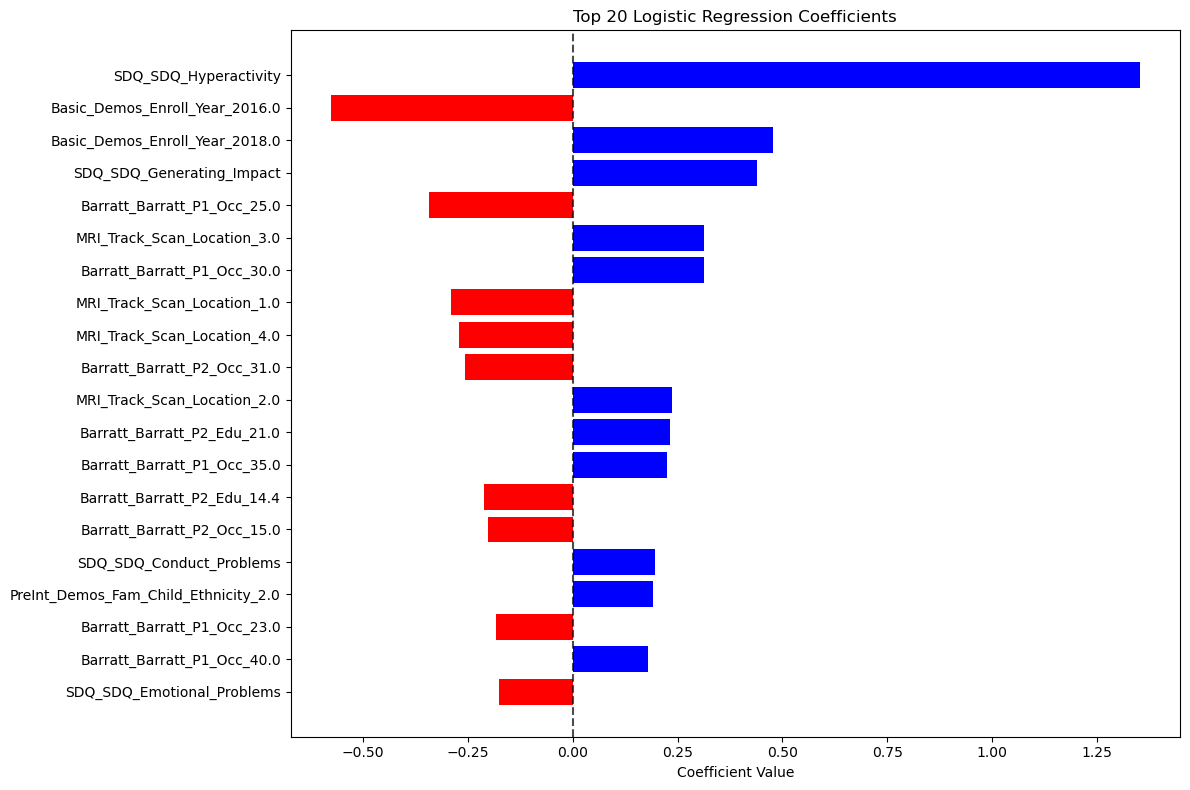

In [ ]:
#
print("="*60)

feature_names = X_train.columns
coefficients = grid_search.best_estimator_.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names, 
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("Top 10 most influential features:")
print(coef_df.head(10)[['Feature', 'Coefficient']].to_string(index=False))

# Plot top 20 coefficients
plt.figure(figsize=(12, 8))
top_20 = coef_df.head(20)
colors = ['red' if coef < 0 else 'blue' for coef in top_20['Coefficient']]
plt.barh(range(len(top_20)), top_20['Coefficient'], color=colors)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ROC CURVE ANALYSIS


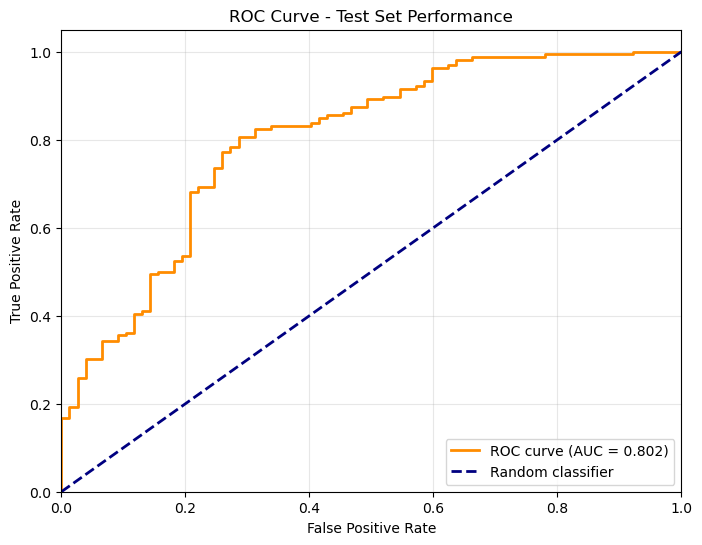

Test set ROC AUC: 0.8017


In [ ]:
#
print("ROC CURVE ANALYSIS")


y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set Performance')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Test set ROC AUC: {roc_auc:.4f}")

An AUC of 0.8 in predicting ADHD cases means the model can correctly rank an ADHD case above a non-ADHD case 80% of the time. From a healthcare perspective, this is strong evidence the model can be used as a screening tool — for example, to prioritize which children should be referred for full clinical diagnosis. This improves efficiency by reducing wasted clinical resources while also supporting earlier interventions for children who are truly at risk

In [20]:

print("THRESHOLD OPTIMIZATION")


thresholds_range = np.arange(0.1, 0.9, 0.01)
f1_scores = []
precisions_1 = []
recalls_1 = []

for thresh in thresholds_range:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    report = classification_report(y_test, y_pred_thresh, output_dict=True, zero_division=0)
    f1_scores.append(report['macro avg']['f1-score'])
    precisions_1.append(report['1']['precision'])
    recalls_1.append(report['1']['recall'])

THRESHOLD OPTIMIZATION


In [23]:
# evalauting model on the untocuhed test set - chosen model is LR 
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_range[optimal_idx]
max_f1 = f1_scores[optimal_idx]
y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
y_test_pred_custom = (y_test_proba >= optimal_threshold).astype(int)
print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Maximum macro F1-score: {max_f1:.4f}")


Optimal threshold: 0.45
Maximum macro F1-score: 0.7523


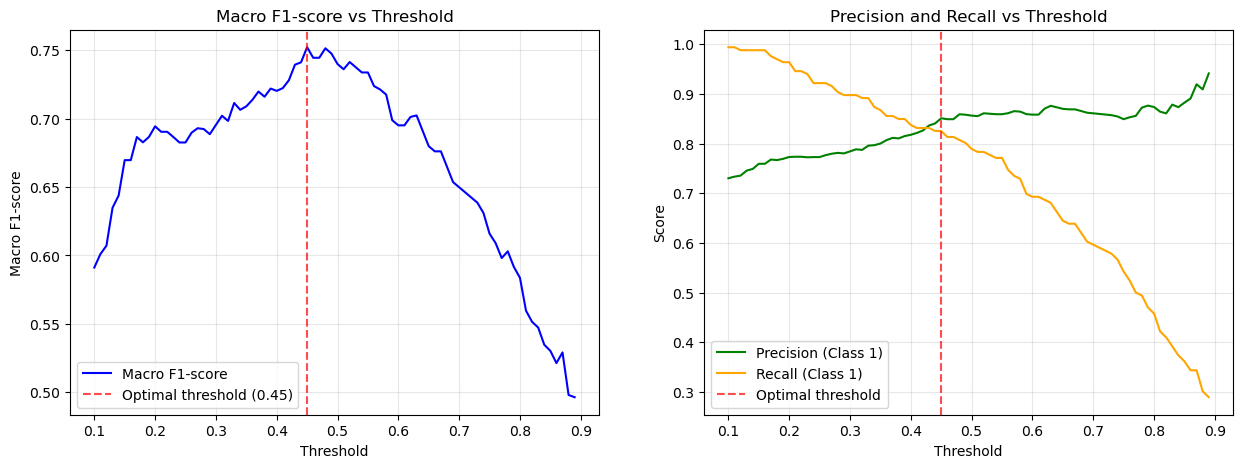

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(thresholds_range, f1_scores, label='Macro F1-score', color='blue')
ax1.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal threshold ({optimal_threshold:.2f})')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Macro F1-score')
ax1.set_title('Macro F1-score vs Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(thresholds_range, precisions_1, label='Precision (Class 1)', color='green')
ax2.plot(thresholds_range, recalls_1, label='Recall (Class 1)', color='orange')
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal threshold')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Precision and Recall vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)


In [28]:
seeds = [21, 42, 100, 123, 2025, 777, 999, 1234, 5678, 9999]
stability_results = []

print("Testing model stability across different random seeds...")
for seed in seeds:
    # Split data with different seed
    X_temp_seed, X_test_seed, y_temp_seed, y_test_seed = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    X_train_seed, X_val_seed, y_train_seed, y_val_seed = train_test_split(
        X_temp_seed, y_temp_seed, test_size=0.25, random_state=seed, stratify=y_temp_seed
    )
    
    # Train model with best parameters
    lr_seed = LogisticRegression(
        max_iter=1000, 
        random_state=seed, 
        class_weight='balanced',
        **grid_search.best_params_
    )
    lr_seed.fit(X_train_seed, y_train_seed)
    
    # Evaluate on test set
    y_test_proba_seed = lr_seed.predict_proba(X_test_seed)[:, 1]
    y_test_pred_seed = (y_test_proba_seed >= optimal_threshold).astype(int)
    
    report_seed = classification_report(y_test_seed, y_test_pred_seed, output_dict=True)
    
    stability_results.append({
        'seed': seed,
        'accuracy': accuracy_score(y_test_seed, y_test_pred_seed),
        'f1_macro': report_seed['macro avg']['f1-score'],
        'precision_1': report_seed['1']['precision'],
        'recall_1': report_seed['1']['recall'],
        'auc': auc(*roc_curve(y_test_seed, y_test_proba_seed)[:2])
    })

stability_df = pd.DataFrame(stability_results)

print(f"\nStability Results Summary (n={len(seeds)} seeds):")

for metric in ['accuracy', 'f1_macro', 'precision_1', 'recall_1', 'auc']:
    mean_val = stability_df[metric].mean()
    std_val = stability_df[metric].std()
    print(f"{metric.replace('_', ' ').title():<15}: {mean_val:.4f} ± {std_val:.4f}")



Testing model stability across different random seeds...

Stability Results Summary (n=10 seeds):
Accuracy       : 0.7811 ± 0.0259
F1 Macro       : 0.7537 ± 0.0292
Precision 1    : 0.8584 ± 0.0244
Recall 1       : 0.8145 ± 0.0289
Auc            : 0.8412 ± 0.0263


In [29]:
# Final Test Set Evaluation

print("FINAL TEST SET EVALUATION")

y_test_pred_final = (y_test_proba >= optimal_threshold).astype(int)
report_final = classification_report(y_test, y_test_pred_final, output_dict=True)

print(f"Using optimal threshold: {optimal_threshold:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_final):.4f}")
print(f"Macro F1-score: {report_final['macro avg']['f1-score']:.4f}")
print(f"Precision (Class 0): {report_final['0']['precision']:.4f}")
print(f"Precision (Class 1): {report_final['1']['precision']:.4f}")
print(f"Recall (Class 0): {report_final['0']['recall']:.4f}")
print(f"Recall (Class 1): {report_final['1']['recall']:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


FINAL TEST SET EVALUATION
Using optimal threshold: 0.45
Accuracy: 0.7819
Macro F1-score: 0.7523
Precision (Class 0): 0.6463
Precision (Class 1): 0.8509
Recall (Class 0): 0.6883
Recall (Class 1): 0.8253
ROC AUC: 0.8017


In [30]:
print("\n" + "="*60)
print("CLINICAL INTERPRETATION")

print(f"• ROC AUC of {roc_auc:.3f} indicates strong discriminative ability")
print(f"• Model can correctly rank ADHD cases above non-ADHD cases {roc_auc*100:.1f}% of the time")
print(f"• Suitable for use as a screening tool to prioritize clinical assessments")
print(f"• Recall for ADHD cases: {report_final['1']['recall']:.3f} (identifies {report_final['1']['recall']*100:.1f}% of true ADHD cases)")
print(f"• Precision for ADHD cases: {report_final['1']['precision']:.3f} ({report_final['1']['precision']*100:.1f}% of predicted ADHD cases are correct)")


CLINICAL INTERPRETATION
• ROC AUC of 0.802 indicates strong discriminative ability
• Model can correctly rank ADHD cases above non-ADHD cases 80.2% of the time
• Suitable for use as a screening tool to prioritize clinical assessments
• Recall for ADHD cases: 0.825 (identifies 82.5% of true ADHD cases)
• Precision for ADHD cases: 0.851 (85.1% of predicted ADHD cases are correct)


In [31]:
import joblib
joblib.dump(grid_search.best_estimator_, 'logistic_regression_model.joblib')
import json
with open('adhd_lr_threshold.json', 'w') as f:
    json.dump({'threshold':0.45}, f)



In [32]:
model = joblib.load('logistic_regression_model.joblib')
with open('adhd_lr_threshold.json', 'r') as f:
    threshold = json.load(f)['threshold']

In [33]:

print("MODEL DEVELOPMENT SUMMARY")
print("="*60)
print(f"• Best hyperparameters: {grid_search.best_params_}")
print(f"• Optimal threshold: {optimal_threshold:.2f}")
print(f"• Test set performance: {report_final['macro avg']['f1-score']:.4f} F1-Macro")
print(f"• Model stability: {stability_df['f1_macro'].std():.4f} std dev across seeds")
print(f"• Clinical utility: {roc_auc:.3f} AUC for screening applications")

MODEL DEVELOPMENT SUMMARY
• Best hyperparameters: {'C': 0.1, 'solver': 'lbfgs'}
• Optimal threshold: 0.45
• Test set performance: 0.7523 F1-Macro
• Model stability: 0.0292 std dev across seeds
• Clinical utility: 0.802 AUC for screening applications
